---
# 
---

In this notebook

### Loading necessary libraries

In [8]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import joblib

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### Define files

In [72]:
#data_dir = '../data/'
data_dir = 'C:\\Users\\jocl0\\ABF\\Final_Project-main\\data\\'

model_dir = 'C:\\Users\\jocl0\\ABF\\Final_Project-main\\model\\'
#model_dir = '../model/'

#ghg = 'GreenHouse_Gases/processed/'
ghg = 'GreenHouse_Gases\\processed\\'

frequency = 'DLY'

climate_file = 'ECCC\\processed\\daily\\daily_processed.csv'
#climate_file = 'ECCC/processed/daily/daily_processed.csv'
#climate_file = 'ECCC/processed/monthly/monthly_processed.csv'

population_file = 'Population\\processed\\Montreal.csv'
#population_file = 'Population/processed/Montreal.csv'

#co2_file = 'co2_1850-2099_SSP2_45.csv'
#ch4_file = 'ch4_1850-2099_SSP2_45.csv'

ghg_files = {'co2_file_weak' : 'co2_1850-2099_SSP4_34.csv',
             'ch4_file_weak' : 'ch4_1850-2099_SSP4_34.csv',
             'co2_file_mod'  : 'co2_1850-2099_SSP2_45.csv',
             'ch4_file_mod'  : 'ch4_1850-2099_SSP2_45.csv',
             'co2_file_high' : 'co2_1850-2099_SSP4_60.csv',
             'ch4_file_high' : 'ch4_1850-2099_SSP4_60.csv',
             'co2_file_xtrm' : 'co2_1850-2099_SSP5_85.csv',
             'ch4_file_xtrm' : 'ch4_1850-2099_SSP5_85.csv',
             }

scenario = {'weak' : 'SSP4-34',
            'mod' : 'SSP2-45',
            'high' : 'SSP4-60',
            'xtrm' : 'SSP5-85', 
           }

### Define variables

**Daily**

In [12]:
Tmax = 'Max Temp (°C)'
Tmin =  'Min Temp (°C)' 

yr_start_prediction = 2025
start_prediction = '2025-01-01'

yr_end_prediction = 2050
end_prediction = '2050-01-01'

### Read data files

In [124]:
for idx, sc in enumerate(scenario):
    tmp_sc = scenario[sc].replace('-', '_')

    for gas in ['co2', 'ch4']:
        file = gas + '_file_' + sc

        if idx == 0 :
            if gas == 'co2':
                co2_df = pd.read_csv(os.path.join(data_dir, ghg, ghg_files[file]), index_col = 0, parse_dates=True)
                co2_df.drop(columns = ['Data Source'], inplace=True)
                co2_df.rename(columns={'CO2': 'CO2_' + sc}, inplace=True)
            elif gas == 'ch4':
                ch4_df = pd.read_csv(os.path.join(data_dir, ghg, ghg_files[file]), index_col = 0, parse_dates=True)
                ch4_df.rename(columns={'CH4': 'CH4_' + sc}, inplace=True)
            else:
                print('Error: Gas is not co2 or ch4')
        else:
            if gas == 'co2':
                tmp = pd.read_csv(os.path.join(data_dir, ghg, ghg_files[file]), index_col = 0, parse_dates=True)
                tmp.drop(columns = ['Data Source'], inplace=True)
                tmp.rename(columns={'CO2': 'CO2_' + sc}, inplace=True)
                co2_df = pd.concat([co2_df, tmp], axis=1)
            elif gas == 'ch4':
                tmp = pd.read_csv(os.path.join(data_dir, ghg, ghg_files[file]), index_col = 0, parse_dates=True)
                tmp.rename(columns={'CH4': 'CH4_' + sc}, inplace=True)
                ch4_df = pd.concat([ch4_df, tmp], axis=1)
            else:
                print('Error: Gas is not co2 or ch4')

In [126]:
co2_df

,CO2_weak,CO2_mod,CO2_high,CO2_xtrm
Year,,,,
1850-01-01,285.200000,285.200000,285.200000,285.200000
1851-01-01,285.100000,285.100000,285.100000,285.100000
1852-01-01,285.000000,285.000000,285.000000,285.000000
1853-01-01,285.000000,285.000000,285.000000,285.000000
1854-01-01,284.900000,284.900000,284.900000,284.900000
...,...,...,...,...
2095-01-01,480.464020,600.885986,659.567993,1066.849854
2096-01-01,479.184021,601.365967,661.474976,1080.529907
2097-01-01,477.835022,601.796997,663.311951,1094.209839


In [128]:
ch4_df

,CH4_weak,CH4_mod,CH4_high,CH4_xtrm
Year,,,,
1850-01-01,791.600000,791.600000,791.600000,791.600000
1851-01-01,792.859068,792.859068,792.859068,792.859068
1852-01-01,794.156502,794.156502,794.156502,794.156502
1853-01-01,795.493289,795.493289,795.493289,795.493289
1854-01-01,796.859405,796.859405,796.859405,796.859405
...,...,...,...,...
2095-01-01,2357.659912,1698.879883,2662.159912,2478.709473
2096-01-01,2353.679688,1695.429810,2658.899902,2465.519287
2097-01-01,2349.539795,1692.139893,2655.599854,2452.609375


In [130]:
pop_df = pd.read_csv(os.path.join(data_dir, population_file), index_col=0, parse_dates=True)
pop_df

,Population
1801-01-01,9.000000e+03
1802-01-01,9.389547e+03
1803-01-01,9.788026e+03
1804-01-01,1.019544e+04
1805-01-01,1.061293e+04
...,...
2095-01-01,2.258385e+06
2096-01-01,2.249969e+06
2097-01-01,2.240726e+06
2098-01-01,2.230707e+06


In [88]:
wx_df = pd.read_csv(os.path.join(data_dir, climate_file), index_col=0, parse_dates=True)
wx_df

C:\Users\jocl0\AppData\Local\Temp\ipykernel_65652\1851272773.py:1: DtypeWarning: Columns (5,11,13,15,17,19,27,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  wx_df = pd.read_csv(os.path.join(data_dir, climate_file), index_col=0, parse_dates=True)


,Station,Longitude (x),Latitude (y),Station Name,Climate ID,Year,Month,Day,Data Quality,Max Temp (°C),...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
Date/Time,,,,,,,,,,,,,,,,,,,,,
1891-10-22,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,22,NaN,5.6,...,0.0,T,0.0,T,NaN,NaN,NaN,NaN,NaN,NaN
1891-10-23,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,23,NaN,3.9,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1891-10-24,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,24,NaN,5.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1891-10-25,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,25,NaN,3.3,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1891-10-26,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,26,NaN,10.6,...,0.0,NaN,4.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-23,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2025,3,23,NaN,-1.6,...,NaN,NaN,0.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN
2025-03-24,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2025,3,24,NaN,3.9,...,NaN,NaN,6.7,NaN,9.0,NaN,NaN,NaN,NaN,NaN
2025-03-25,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2025,3,25,NaN,4.5,...,NaN,NaN,1.1,NaN,11.0,NaN,NaN,NaN,NaN,NaN


### Adding columns of lagged temperature features (yesterday's min/max temperature)

In [90]:
wx_df['tmin_lag1'] = wx_df[Tmin].shift(1)
wx_df['tmax_lag1'] = wx_df[Tmax].shift(1)
wx_df

,Station,Longitude (x),Latitude (y),Station Name,Climate ID,Year,Month,Day,Data Quality,Max Temp (°C),...,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag,tmin_lag1,tmax_lag1
Date/Time,,,,,,,,,,,,,,,,,,,,,
1891-10-22,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,22,NaN,5.6,...,0.0,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1891-10-23,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,23,NaN,3.9,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.7,5.6
1891-10-24,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,24,NaN,5.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.1,3.9
1891-10-25,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,25,NaN,3.3,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.2,5.0
1891-10-26,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,26,NaN,10.6,...,4.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.3,3.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-23,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2025,3,23,NaN,-1.6,...,0.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,-7.5,10.7
2025-03-24,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2025,3,24,NaN,3.9,...,6.7,NaN,9.0,NaN,NaN,NaN,NaN,NaN,-9.8,-1.6
2025-03-25,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2025,3,25,NaN,4.5,...,1.1,NaN,11.0,NaN,NaN,NaN,NaN,NaN,-4.6,3.9


### Keep climate data for prediction starting at 2025

In [93]:
start = pd.to_datetime(yr_start_prediction, format='%Y') - pd.Timedelta(31, unit='D')
start

Timestamp('2024-12-01 00:00:00')

In [95]:
wx_df = wx_df[wx_df.index >= start]
wx_df

,Station,Longitude (x),Latitude (y),Station Name,Climate ID,Year,Month,Day,Data Quality,Max Temp (°C),...,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag,tmin_lag1,tmax_lag1
Date/Time,,,,,,,,,,,,,,,,,,,,,
2024-12-01,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2024,12,1,NaN,0.6,...,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.9,1.7
2024-12-02,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2024,12,2,NaN,-0.2,...,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.3,0.6
2024-12-03,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2024,12,3,NaN,-0.2,...,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.3,-0.2
2024-12-04,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2024,12,4,NaN,-0.2,...,3.4,NaN,0.0,NaN,NaN,NaN,NaN,NaN,-4.2,-0.2
2024-12-05,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2024,12,5,NaN,1.1,...,4.7,NaN,7.0,NaN,NaN,NaN,NaN,NaN,-4.9,-0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-23,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2025,3,23,NaN,-1.6,...,0.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,-7.5,10.7
2025-03-24,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2025,3,24,NaN,3.9,...,6.7,NaN,9.0,NaN,NaN,NaN,NaN,NaN,-9.8,-1.6
2025-03-25,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2025,3,25,NaN,4.5,...,1.1,NaN,11.0,NaN,NaN,NaN,NaN,NaN,-4.6,3.9


In [97]:
start_wx = wx_df.index.min()
end_wx = wx_df.index.max()

In [99]:
print(start_wx, end_wx)

2024-12-01 00:00:00 2025-03-27 00:00:00


### Remove incomplete start and end year of climate dataset

### Put the GreenHouse Gases dataframe and population dataframe on the same frequency as the climate data

In [132]:
new_range = pd.date_range(start = pd.to_datetime(yr_start_prediction -1 , format='%Y'), end = pd.to_datetime(yr_end_prediction, format='%Y'), freq="D")
print(new_range)
    
new_co2_df = co2_df.reindex(new_range)
new_co2_df = co2_df.resample('D').interpolate()

new_ch4_df = ch4_df.reindex(new_range)
new_ch4_df = ch4_df.resample('D').interpolate()

new_pop_df = pop_df.reindex(new_range)
new_pop_df = pop_df.resample('D').interpolate()

DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08',
               '2024-01-09', '2024-01-10',
               ...
               '2049-12-23', '2049-12-24', '2049-12-25', '2049-12-26',
               '2049-12-27', '2049-12-28', '2049-12-29', '2049-12-30',
               '2049-12-31', '2050-01-01'],
              dtype='datetime64[ns]', length=9498, freq='D')


In [140]:
new_co2_df = new_co2_df[new_co2_df.index >= start_wx] 

new_ch4_df = new_ch4_df[new_ch4_df.index >= start_wx]

new_pop_df = new_pop_df[new_pop_df.index >= start_wx]

In [142]:
new_co2_df

,CO2_weak,CO2_mod,CO2_high,CO2_xtrm
Year,,,,
2024-12-01,426.983897,427.526737,427.501587,428.240532
2024-12-02,426.990983,427.535444,427.510219,428.251369
2024-12-03,426.998070,427.544151,427.518850,428.262207
2024-12-04,427.005156,427.552857,427.527482,428.273044
2024-12-05,427.012242,427.561564,427.536114,428.283882
...,...,...,...,...
2098-12-28,474.949288,602.501410,666.758369,1121.400228
2098-12-29,474.945220,602.502309,666.763021,1121.437653
2098-12-30,474.941151,602.503208,666.767673,1121.475077


In [144]:
new_ch4_df

,CH4_weak,CH4_mod,CH4_high,CH4_xtrm
Year,,,,
2024-12-01,1952.516422,1946.157773,1982.889787,1942.939887
2024-12-02,1952.559809,1946.191670,1982.975949,1942.971335
2024-12-03,1952.603196,1946.225568,1983.062111,1943.002782
2024-12-04,1952.646583,1946.259465,1983.148274,1943.034229
2024-12-05,1952.689970,1946.293363,1983.234436,1943.065677
...,...,...,...,...
2098-12-28,2340.908191,1686.052664,2648.946626,2427.665408
2098-12-29,2340.896109,1686.044473,2648.937447,2427.631380
2098-12-30,2340.884027,1686.036281,2648.928269,2427.597353


In [154]:
new_pop_df

,Population
2024-12-01,2.185184e+06
2024-12-02,2.185137e+06
2024-12-03,2.185091e+06
2024-12-04,2.185044e+06
2024-12-05,2.184997e+06
...,...
2098-12-28,2.220005e+06
2098-12-29,2.219975e+06
2098-12-30,2.219945e+06
2098-12-31,2.219916e+06


### Create dataframe needed to forecast

In [185]:
start_fcst = pd.to_datetime(yr_start_prediction, format='%Y')
x_fcst_df = pd.concat([new_co2_df[new_co2_df.index >= start_fcst],  new_ch4_df[new_ch4_df.index >= start_fcst], new_pop_df[new_pop_df.index >= start_fcst]], axis=1)
x_fcst_df

,CO2_weak,CO2_mod,CO2_high,CO2_xtrm,CH4_weak,CH4_mod,CH4_high,CH4_xtrm,Population
2025-01-01,427.203571,427.796644,427.769167,428.576492,1953.861413,1947.208593,1985.560821,1943.914755,2.183738e+06
2025-01-02,427.210499,427.805347,427.777882,428.587605,1953.903578,1947.240491,1985.644584,1943.948321,2.183567e+06
2025-01-03,427.217428,427.814051,427.786597,428.598718,1953.945744,1947.272390,1985.728346,1943.981887,2.183395e+06
2025-01-04,427.224356,427.822754,427.795313,428.609831,1953.987910,1947.304288,1985.812108,1944.015453,2.183223e+06
2025-01-05,427.231285,427.831457,427.804028,428.620944,1954.030076,1947.336187,1985.895870,1944.049019,2.183052e+06
...,...,...,...,...,...,...,...,...,...
2098-12-28,474.949288,602.501410,666.758369,1121.400228,2340.908191,1686.052664,2648.946626,2427.665408,2.220005e+06
2098-12-29,474.945220,602.502309,666.763021,1121.437653,2340.896109,1686.044473,2648.937447,2427.631380,2.219975e+06
2098-12-30,474.941151,602.503208,666.767673,1121.475077,2340.884027,1686.036281,2648.928269,2427.597353,2.219945e+06
2098-12-31,474.937082,602.504106,666.772325,1121.512502,2340.871945,1686.028089,2648.919090,2427.563325,2.219916e+06


In [187]:
x_fcst_df['dayofyear'] = x_fcst_df.index.dayofyear
x_fcst_df['sin'] = 80 * np.sin((np.pi/(365+31)) * x_fcst_df['dayofyear']) -30
x_fcst_df

,CO2_weak,CO2_mod,CO2_high,CO2_xtrm,CH4_weak,CH4_mod,CH4_high,CH4_xtrm,Population,dayofyear,sin
2025-01-01,427.203571,427.796644,427.769167,428.576492,1953.861413,1947.208593,1985.560821,1943.914755,2.183738e+06,1,-29.365341
2025-01-02,427.210499,427.805347,427.777882,428.587605,1953.903578,1947.240491,1985.644584,1943.948321,2.183567e+06,2,-28.730723
2025-01-03,427.217428,427.814051,427.786597,428.598718,1953.945744,1947.272390,1985.728346,1943.981887,2.183395e+06,3,-28.096184
2025-01-04,427.224356,427.822754,427.795313,428.609831,1953.987910,1947.304288,1985.812108,1944.015453,2.183223e+06,4,-27.461765
2025-01-05,427.231285,427.831457,427.804028,428.620944,1954.030076,1947.336187,1985.895870,1944.049019,2.183052e+06,5,-26.827506
...,...,...,...,...,...,...,...,...,...,...,...
2098-12-28,474.949288,602.501410,666.758369,1121.400228,2340.908191,1686.052664,2648.946626,2427.665408,2.220005e+06,362,-8.682095
2098-12-29,474.945220,602.502309,666.763021,1121.437653,2340.896109,1686.044473,2648.937447,2427.631380,2.219975e+06,363,-9.294476
2098-12-30,474.941151,602.503208,666.767673,1121.475077,2340.884027,1686.036281,2648.928269,2427.597353,2.219945e+06,364,-9.908161
2098-12-31,474.937082,602.504106,666.772325,1121.512502,2340.871945,1686.028089,2648.919090,2427.563325,2.219916e+06,365,-10.523110


### Put all the data into a single dataframe

In [190]:
full_df = pd.concat([ new_co2_df[new_co2_df.index <= end_wx],  new_ch4_df[new_ch4_df.index <= end_wx], new_pop_df[new_pop_df.index <= end_wx], wx_df[[Tmax,Tmin]]], axis=1)
full_df

,CO2_weak,CO2_mod,CO2_high,CO2_xtrm,CH4_weak,CH4_mod,CH4_high,CH4_xtrm,Population,Max Temp (°C),Min Temp (°C)
2024-12-01,426.983897,427.526737,427.501587,428.240532,1952.516422,1946.157773,1982.889787,1942.939887,2.185184e+06,0.6,-3.3
2024-12-02,426.990983,427.535444,427.510219,428.251369,1952.559809,1946.191670,1982.975949,1942.971335,2.185137e+06,-0.2,-4.3
2024-12-03,426.998070,427.544151,427.518850,428.262207,1952.603196,1946.225568,1983.062111,1943.002782,2.185091e+06,-0.2,-4.2
2024-12-04,427.005156,427.552857,427.527482,428.273044,1952.646583,1946.259465,1983.148274,1943.034229,2.185044e+06,-0.2,-4.9
2024-12-05,427.012242,427.561564,427.536114,428.283882,1952.689970,1946.293363,1983.234436,1943.065677,2.184997e+06,1.1,-4.2
...,...,...,...,...,...,...,...,...,...,...,...
2025-03-23,427.764768,428.501597,428.475103,429.476655,1957.276839,1949.792374,1992.345555,1946.633590,2.169838e+06,-1.6,-9.8
2025-03-24,427.771697,428.510300,428.483819,429.487769,1957.319005,1949.824273,1992.429317,1946.667156,2.169666e+06,3.9,-4.6
2025-03-25,427.778625,428.519003,428.492534,429.498882,1957.361170,1949.856172,1992.513080,1946.700721,2.169494e+06,4.5,0.9
2025-03-26,427.785553,428.527706,428.501249,429.509995,1957.403336,1949.888070,1992.596842,1946.734287,2.169323e+06,4.8,-0.3


### Add lagged temperature features

In [192]:
full_df['tmin_lag1'] = wx_df['tmin_lag1']
full_df['tmax_lag1'] = wx_df['tmax_lag1']
full_df

,CO2_weak,CO2_mod,CO2_high,CO2_xtrm,CH4_weak,CH4_mod,CH4_high,CH4_xtrm,Population,Max Temp (°C),Min Temp (°C),tmin_lag1,tmax_lag1
2024-12-01,426.983897,427.526737,427.501587,428.240532,1952.516422,1946.157773,1982.889787,1942.939887,2.185184e+06,0.6,-3.3,-0.9,1.7
2024-12-02,426.990983,427.535444,427.510219,428.251369,1952.559809,1946.191670,1982.975949,1942.971335,2.185137e+06,-0.2,-4.3,-3.3,0.6
2024-12-03,426.998070,427.544151,427.518850,428.262207,1952.603196,1946.225568,1983.062111,1943.002782,2.185091e+06,-0.2,-4.2,-4.3,-0.2
2024-12-04,427.005156,427.552857,427.527482,428.273044,1952.646583,1946.259465,1983.148274,1943.034229,2.185044e+06,-0.2,-4.9,-4.2,-0.2
2024-12-05,427.012242,427.561564,427.536114,428.283882,1952.689970,1946.293363,1983.234436,1943.065677,2.184997e+06,1.1,-4.2,-4.9,-0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-23,427.764768,428.501597,428.475103,429.476655,1957.276839,1949.792374,1992.345555,1946.633590,2.169838e+06,-1.6,-9.8,-7.5,10.7
2025-03-24,427.771697,428.510300,428.483819,429.487769,1957.319005,1949.824273,1992.429317,1946.667156,2.169666e+06,3.9,-4.6,-9.8,-1.6
2025-03-25,427.778625,428.519003,428.492534,429.498882,1957.361170,1949.856172,1992.513080,1946.700721,2.169494e+06,4.5,0.9,-4.6,3.9
2025-03-26,427.785553,428.527706,428.501249,429.509995,1957.403336,1949.888070,1992.596842,1946.734287,2.169323e+06,4.8,-0.3,0.9,4.5


In [194]:
full_df['dayofyear'] = full_df.index.dayofyear
full_df['sin'] = 80 * np.sin((np.pi/(365+31)) * full_df['dayofyear']) -30

full_df

,CO2_weak,CO2_mod,CO2_high,CO2_xtrm,CH4_weak,CH4_mod,CH4_high,CH4_xtrm,Population,Max Temp (°C),Min Temp (°C),tmin_lag1,tmax_lag1,dayofyear,sin
2024-12-01,426.983897,427.526737,427.501587,428.240532,1952.516422,1946.157773,1982.889787,1942.939887,2.185184e+06,0.6,-3.3,-0.9,1.7,336,6.658122
2024-12-02,426.990983,427.535444,427.510219,428.251369,1952.559809,1946.191670,1982.975949,1942.971335,2.185137e+06,-0.2,-4.3,-3.3,0.6,337,6.092861
2024-12-03,426.998070,427.544151,427.518850,428.262207,1952.603196,1946.225568,1983.062111,1943.002782,2.185091e+06,-0.2,-4.2,-4.3,-0.2,338,5.525329
2024-12-04,427.005156,427.552857,427.527482,428.273044,1952.646583,1946.259465,1983.148274,1943.034229,2.185044e+06,-0.2,-4.9,-4.2,-0.2,339,4.955561
2024-12-05,427.012242,427.561564,427.536114,428.283882,1952.689970,1946.293363,1983.234436,1943.065677,2.184997e+06,1.1,-4.2,-4.9,-0.2,340,4.383593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-23,427.764768,428.501597,428.475103,429.476655,1957.276839,1949.792374,1992.345555,1946.633590,2.169838e+06,-1.6,-9.8,-7.5,10.7,82,18.448775
2025-03-24,427.771697,428.510300,428.483819,429.487769,1957.319005,1949.824273,1992.429317,1946.667156,2.169666e+06,3.9,-4.6,-9.8,-1.6,83,18.952287
2025-03-25,427.778625,428.519003,428.492534,429.498882,1957.361170,1949.856172,1992.513080,1946.700721,2.169494e+06,4.5,0.9,-4.6,3.9,84,19.452719
2025-03-26,427.785553,428.527706,428.501249,429.509995,1957.403336,1949.888070,1992.596842,1946.734287,2.169323e+06,4.8,-0.3,0.9,4.5,85,19.950038


### Separate RNN input and output data

In [424]:
sc = 'xtrm'

In [426]:
cols_in = ['CH4', 'CO2', 'Population', 'tmin_lag1', 'tmax_lag1', 'sin']

cols_in_past = ['CH4'+'_'+sc, 'CO2'+'_'+sc, 'Population', 'tmin_lag1', 'tmax_lag1', 'sin'] #, 'sin_doy', 'cos_doy'] #'dayofyear']
cols_in_pred = ['CH4'+'_'+sc, 'CO2'+'_'+sc, 'Population', 'sin']

cols_out = [Tmax, Tmin]

X_past = full_df[cols_in_past].rename(columns={'CH4'+'_'+sc : 'CH4', 'CO2'+'_'+sc : 'CO2'})
X_pred = x_fcst_df[cols_in_pred].rename(columns={'CH4'+'_'+sc : 'CH4', 'CO2'+'_'+sc : 'CO2'})

In [428]:
X_past

,CH4,CO2,Population,tmin_lag1,tmax_lag1,sin
2024-12-01,1942.939887,428.240532,2.185184e+06,-0.9,1.7,6.658122
2024-12-02,1942.971335,428.251369,2.185137e+06,-3.3,0.6,6.092861
2024-12-03,1943.002782,428.262207,2.185091e+06,-4.3,-0.2,5.525329
2024-12-04,1943.034229,428.273044,2.185044e+06,-4.2,-0.2,4.955561
2024-12-05,1943.065677,428.283882,2.184997e+06,-4.9,-0.2,4.383593
...,...,...,...,...,...,...
2025-03-23,1946.633590,429.476655,2.169838e+06,-7.5,10.7,18.448775
2025-03-24,1946.667156,429.487769,2.169666e+06,-9.8,-1.6,18.952287
2025-03-25,1946.700721,429.498882,2.169494e+06,-4.6,3.9,19.452719
2025-03-26,1946.734287,429.509995,2.169323e+06,0.9,4.5,19.950038


In [431]:
X_pred

,CH4,CO2,Population,sin
2025-01-01,1943.914755,428.576492,2.183738e+06,-29.365341
2025-01-02,1943.948321,428.587605,2.183567e+06,-28.730723
2025-01-03,1943.981887,428.598718,2.183395e+06,-28.096184
2025-01-04,1944.015453,428.609831,2.183223e+06,-27.461765
2025-01-05,1944.049019,428.620944,2.183052e+06,-26.827506
...,...,...,...,...
2098-12-28,2427.665408,1121.400228,2.220005e+06,-8.682095
2098-12-29,2427.631380,1121.437653,2.219975e+06,-9.294476
2098-12-30,2427.597353,1121.475077,2.219945e+06,-9.908161
2098-12-31,2427.563325,1121.512502,2.219916e+06,-10.523110


### Scale the dataset

In [433]:
scaler_x = joblib.load(os.path.join(model_dir,'scaler_x.joblib'))
scaler_y = joblib.load(os.path.join(model_dir,'scaler_y.joblib'))

In [435]:
X_scaled_past = scaler_x.transform(X_past)

### Load RNN model

In [437]:
rnn = load_model(os.path.join(model_dir, 'rnn_months_sin_1month_1024k.keras'))

In [439]:
rnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1024)              4222976   
                                                                 
 dense_2 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 4,225,026
Trainable params: 4,225,026
Non-trainable params: 0
_________________________________________________________________


### Evaluate the model on the validation dataset

In [441]:
pd.DataFrame(X_pred.iloc[i]).transpose()

,CH4,CO2,Population,sin
2049-12-31,2446.387389,562.764801,2.082781e+06,-10.52311


In [443]:
wx_df[wx_df.index == '2025-01-01'][cols_out]

,Max Temp (°C),Min Temp (°C)
Date/Time,,
2025-01-01,1.8,0.6


In [ ]:
rnn_prediction_val = []
window_size = 31

date = x_fcst_df[x_fcst_df.index < pd.to_datetime(yr_end_prediction, format='%Y')]

n_steps = len(date)

n_features = X_scaled_past.shape[1]

current_data = X_scaled_past[-(window_size):] 
current_data = current_data.reshape(1, window_size, n_features)

for i in range(n_steps): 
    
    # Prediction for 1 timestep into the future
    current_prediction = rnn.predict(current_data)[0]
    
    # Append it to our list of prediction
    rnn_prediction_val.append(current_prediction)

    #print(current_prediction)
    current_inversed_pred = scaler_y.inverse_transform(current_prediction.reshape(1, -1))[0]
    tmp_df = pd.DataFrame(X_pred.iloc[i]).transpose()
    #print(tmp_df)
    tmp_df['tmax_lag1'] = current_inversed_pred[0]
    tmp_df['tmin_lag1'] = current_inversed_pred[1]
    tmp_df = tmp_df[cols_in]
    X_scaled_pred = scaler_x.transform(tmp_df)
    #print(tmp_df)
    #print(X_scaled_pred)
    #next_input_step = X_scaled_val[i].copy()  
    #next_input_step[-2:] = current_prediction  
    next_input_step = X_scaled_pred.reshape(1, 1, n_features)
    
    current_data = np.append(current_data[:,1:,:], next_input_step, axis=1)

rnn_prediction_val

1/1 [==============================] - 0s 64ms/step


### Inversing prediction

In [453]:
inversed_preds_val = scaler_y.inverse_transform(rnn_prediction_val)

cols_out_new = (pd.Series(cols_out) + 'model').tolist()

end = pd.to_datetime(yr_start_prediction, format='%Y') + pd.Timedelta(n_steps-1, unit='D')
new_range = pd.date_range(start = pd.to_datetime(yr_start_prediction, format='%Y'), end = end, freq="D")

pred_val_df = pd.DataFrame(inversed_preds_val, columns=cols_out_new, index=new_range)
# pred_val_df = pd.DataFrame(inversed_preds_val, columns=cols_out_new)



# pred_val_df = pred_val_df.reindex(new_range)

#full_pred_val_df = pd.concat([full_df.loc[new_range], pred_val_df], axis=1)

#full_pred_val_df

### Look at prediction

<Axes: >

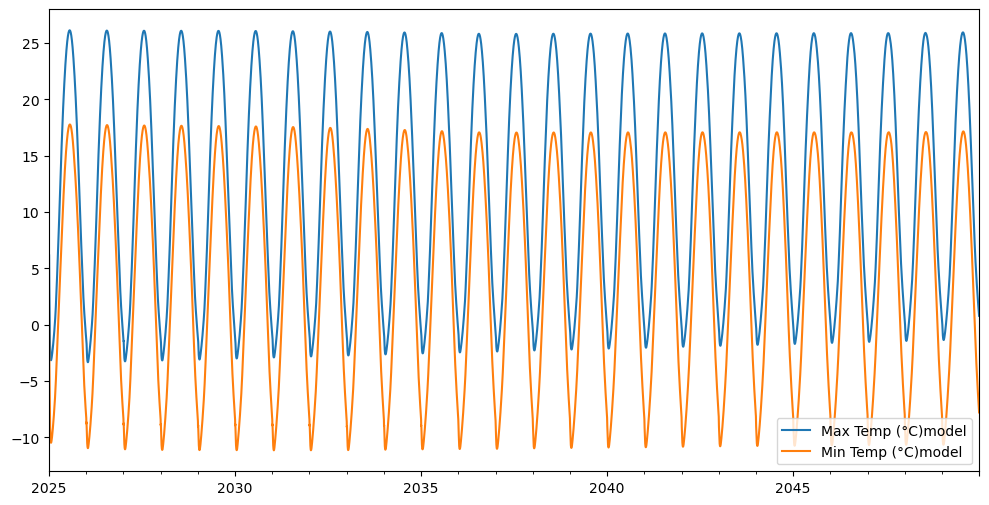

In [455]:
#tmp = full_pred_val_df[['Max Temp (°C)model',	'Min Temp (°C)model', Tmax, Tmin]]
pred_val_df.plot(figsize=(12,6))

### Write data to file 

In [457]:
pred_val_df.to_csv(os.path.join(data_dir, 'Forecast', 'Temperature_'+scenario[sc]))